# Tutorial 5

# Recurrent Neural Networks (RNNs)

## 1. Basic RNN

Lets take a look at the following XBTUSD trading data from BitMex. The daily files are publicly available to [download](https://public.bitmex.com/?prefix=data/trade/). We need the data from 01 November 2020 until 05 November 2020.
(the code from this tutorial is based on the following [post](https://towardsdatascience.com/lstm-for-time-series-prediction-de8aeb26f2ca).) The graphics from the lecture are from the book [Dive into Deep Learning](https://d2l.ai/index.html) (which we really recommend).

Here, we want to predict the Volume Weighted Average Price ([VWAP](https://en.wikipedia.org/wiki/Volume-weighted_average_price)) in 1 minute time intervals.

Formally, at each time step $t\in \mathbb{Z}^+$ we observe some price $X_t$ and would like to model the conditional expectation

$$\mathbb{E}\left[X_t|X_{t-1}=x_{t-1},\dots,X_{1}=x_{1}\right].$$

In [ ]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os
import torch
from torch import nn
import time

In [ ]:
df = pd.read_csv("https://s3-eu-west-1.amazonaws.com/public.bitmex.com/data/trade/20201101.csv.gz")
df = df[df.symbol == 'XBTUSD']
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T')) # covert to timestamp type
df = df.sort_values('timestamp')
df.set_index('timestamp', inplace=True) # set index to timestamp
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2020-11-01 00:00:02.313976,XBTUSD,Buy,960,13802.5,ZeroPlusTick,128116e9-dd6b-6323-8346-17b790f8651c,6955200,0.069552,960.0
2020-11-01 00:00:02.313976,XBTUSD,Buy,40,13802.5,ZeroPlusTick,5d20b5dc-55cf-4166-7311-29fde21e7f1f,289800,0.002898,40.0
2020-11-01 00:00:02.351471,XBTUSD,Buy,962,13802.5,ZeroPlusTick,ed0de8e1-d569-ff41-6354-0601018eb1f0,6969690,0.069697,962.0
2020-11-01 00:00:02.351471,XBTUSD,Buy,263,13802.5,ZeroPlusTick,7dbd2c49-108c-d24a-0b59-69f9e8fb4586,1905435,0.019054,263.0
2020-11-01 00:00:02.351471,XBTUSD,Buy,28,13802.5,ZeroPlusTick,f440fe6e-7049-ecb1-d7a4-68f85b6105c7,202860,0.002029,28.0


Next, we just restrict the data onto the oberservations in $1$ minute intervals, which results in $1440$ observations ($1$ day).

In [ ]:
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: np.sum(row.price * row.foreignNotional) / np.sum(row.foreignNotional))
df_vwap.shape

(1440,)

In [ ]:
df_vwap

,0
timestamp,
2020-11-01 00:00:00,13748.140147
2020-11-01 00:01:00,13738.840556
2020-11-01 00:02:00,13747.822913
2020-11-01 00:03:00,13769.300591
2020-11-01 00:04:00,13794.353039
...,...
2020-11-01 23:55:00,13742.951179
2020-11-01 23:56:00,13751.429141
2020-11-01 23:57:00,13751.801114


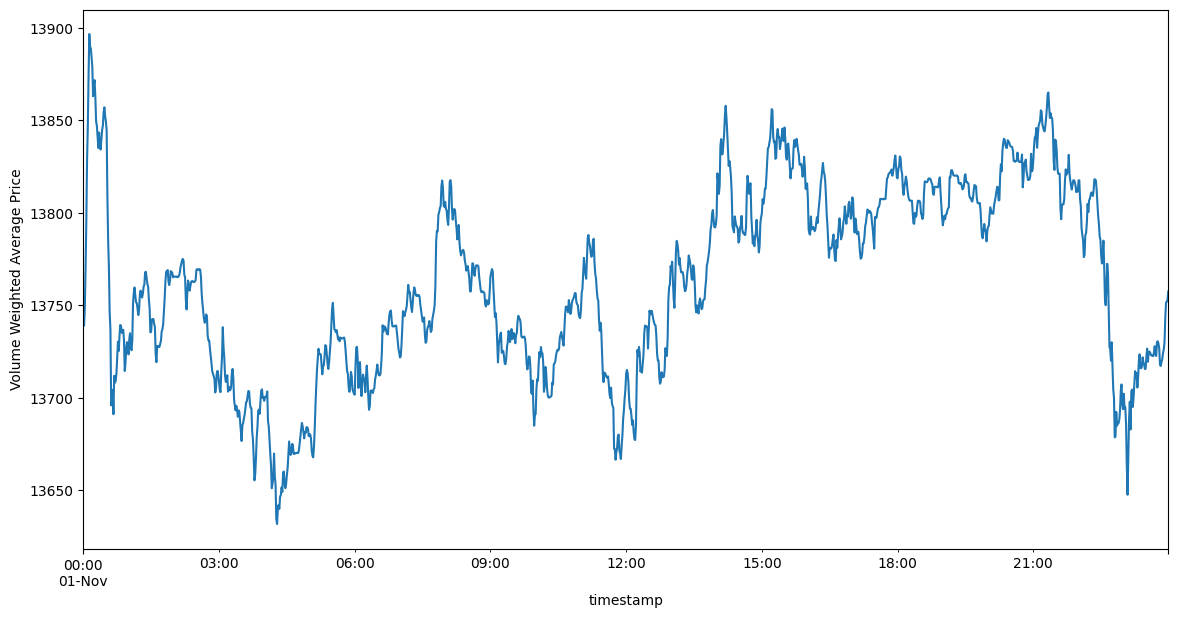

In [ ]:
ax = df_vwap.plot(figsize=(14, 7))
plt.ylabel('Volume Weighted Average Price')
plt.show()

We will use the last $4$ hours as a testing period.

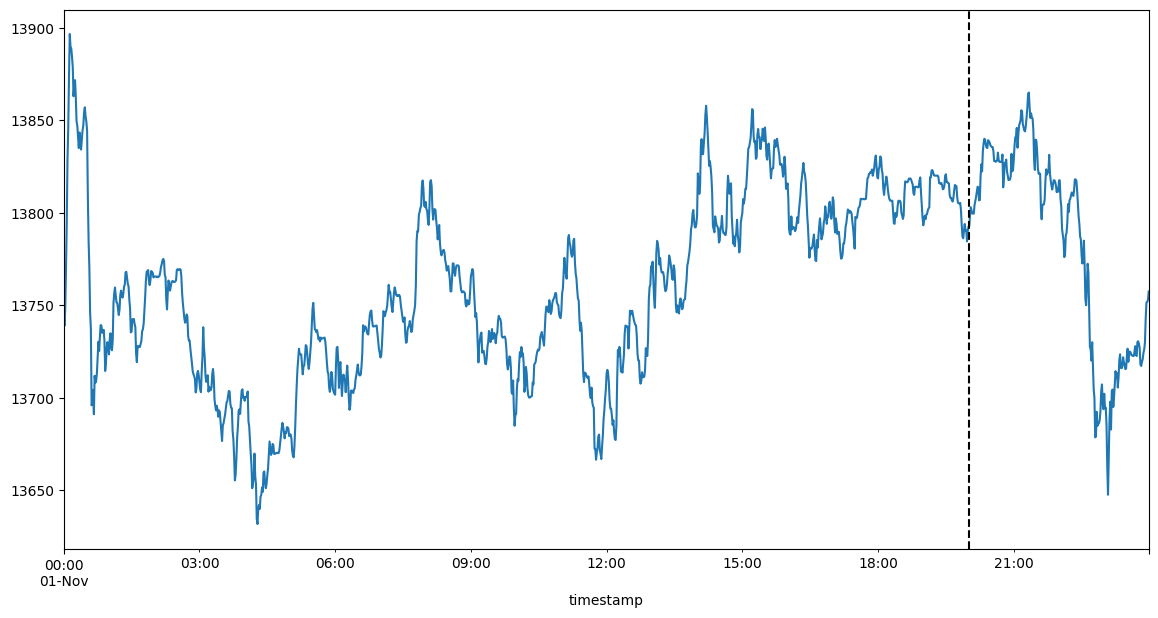

In [ ]:
ax = df_vwap.plot(figsize=(14, 7))
ax.axvline("2020-11-01 20:00:00", linestyle="--", c="black")
plt.show()

In [ ]:
df_train = df_vwap[(df_vwap.index >= "2020-11-01") & (df_vwap.index < "2020-11-01 20:00:00")].to_frame(name="vwap")
df_train.shape

(1200, 1)

In [ ]:
df_test = df_vwap[(df_vwap.index >= "2020-11-01 20:00:00") & (df_vwap.index < "2020-11-02")].to_frame(name='vwap')
df_test.shape

(240, 1)

Machine learning models generally work better with standardized data.

The scaler is fit on the training set and it is used to transform the unseen trade data on the test set.
If we would fit the scaler on all data, the model would overfit and it would achieve good results on this data, but performance would suffer on the real world data.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
test_arr = scaler.transform(df_test)

Next, we partion our sequence to create many subsequences (100 time steps per sequence) that are shifted by a single time step.

In [ ]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len-1):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1:i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len,1)
    y_arr = np.array(y).reshape(-1, seq_len,1)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [ ]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

In [ ]:
x_train.shape

torch.Size([1099, 100, 1])

The plot below shows the first sequence in the training set.

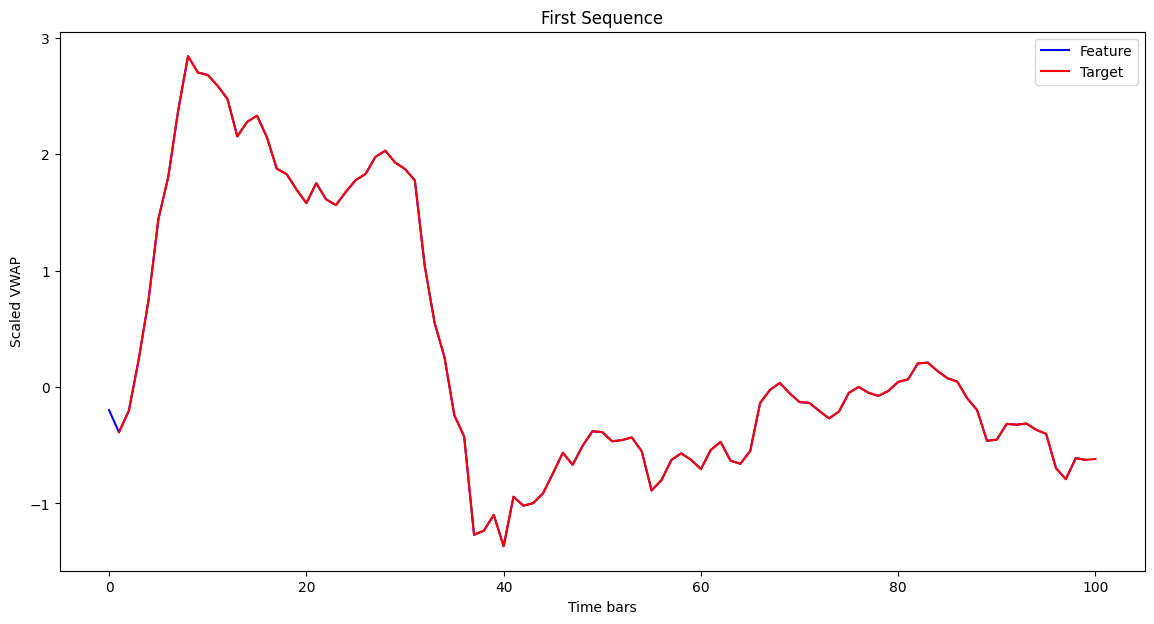

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(range(seq_len), x_train[0].cpu().numpy(), color="b", label="Feature")
plt.plot(range(1,seq_len+1), y_train[0].cpu().numpy(), color="r", label="Target")
plt.title("First Sequence")
plt.xlabel("Time bars")
plt.ylabel("Scaled VWAP")
plt.legend()
plt.show()

How does the RNN use the sequence in the training phase?

* Essentially the first $99$ steps are used to calculate the hidden state $h_{99}$ and
* The final feature at time step $100$ combined with $h_{99}$ tries to predict the price at $X_{101}$ (and simultaneously $h_{100}$).

Note that in classification or regression tasks, we usually have a set of features and a target that we are trying to predict.
In this example with RNN, the feature and the target are from the same sequence, the only difference is that the target is shifted by 1 time bar.

As usually, we have to construct a data loader.

In [ ]:
x_train.shape

torch.Size([1099, 100, 1])

In [ ]:
y_train.shape

torch.Size([1099, 100, 1])

In [ ]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, shuffle=is_train, batch_size=batch_size, drop_last=True)
batch_size = 5
train_loader = load_array((x_train, y_train), batch_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Now, we finally define our network. Here, we define a class, which is the general use of pytorch to define neural networks.
Here, we created our class and added methods for a forward pass through the model and the parameter initialization.

In [ ]:
class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(RNNNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.rnn(x, h)
        out = self.fc(self.relu(out))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

The most interesting part is ``nn.RNN``, which creates a multi-layer Elman RNN.

For each element in the input sequence, each layer (n_layers) computes the following hidden state

$$h_t = \tanh\left(W_{XH}^Tx_t+b_{XH}+W_{HH}^Th_{t-1}+b_{HH}\right),$$

see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN).

Next, we define a function which enables the training of our model.

In [ ]:
n_layers = 1
def train(train_loader, learn_rate,n_layers = n_layers, hidden_dim=20, EPOCHS=5):

    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    # Instantiating the model
    model = RNNNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format("RNN"))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%250 == 0:
                print("Epoch {}\t Step: {}/{}.... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [ ]:
lr = 0.001
rnn_model = train(train_loader, lr,  EPOCHS=3)

Starting Training of RNN model
Epoch 1/3 Done, Total Loss: 0.48785091346325393
Time Elapsed for Epoch: 2.3734900460000006 seconds
Epoch 2/3 Done, Total Loss: 0.058724849701744235
Time Elapsed for Epoch: 2.680895618000001 seconds
Epoch 3/3 Done, Total Loss: 0.0355900724388693
Time Elapsed for Epoch: 3.0072972119999974 seconds
Total Training Time: 8.061682875999999 seconds


Lets evaluate our performance.

In [ ]:
test_data = torch.from_numpy(test_arr.reshape(1,-1,1)).float()
x_test = test_data[:,:-1,:]
y_test = test_data[:,1:,:]

In [ ]:
def m_predict(model,x_test):
    model.eval()
    outputs = torch.tensor([])
    with torch.no_grad():
        h =  torch.zeros(model.n_layers, 1, model.hidden_dim, dtype=torch.float32, device = device)
        out, h = model(x_test.to(device).float(), h)
    return(out.to("cpu"), h)


def evaluate(model,x_test,y_test, criterion = nn.MSELoss()):
    model.eval()
    loss_eval = 0
    start_time = time.process_time()
    h =  torch.zeros(model.n_layers, 1, model.hidden_dim, dtype=torch.float32, device = device)
    out,h = m_predict(model, x_test)
    loss_eval += criterion(out.to(device), y_test.to(device).float())
    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))
    return out.to("cpu").reshape(-1,1), y_test.reshape(-1,1), loss_eval.to("cpu")


In [ ]:
m_predict(rnn_model,x_test = test_data)

(tensor([[[ 0.5282],
          [ 0.9284],
          [ 0.9711],
          [ 0.9266],
          [ 0.9095],
          [ 0.8890],
          [ 0.8702],
          [ 0.8614],
          [ 0.9153],
          [ 0.9905],
          [ 1.0382],
          [ 1.0769],
          [ 1.1235],
          [ 1.1505],
          [ 1.0871],
          [ 1.0123],
          [ 1.1117],
          [ 1.2858],
          [ 1.3480],
          [ 1.3827],
          [ 1.4617],
          [ 1.5219],
          [ 1.5428],
          [ 1.5272],
          [ 1.4988],
          [ 1.4832],
          [ 1.5005],
          [ 1.5267],
          [ 1.5281],
          [ 1.5144],
          [ 1.4996],
          [ 1.4917],
          [ 1.4891],
          [ 1.4785],
          [ 1.4372],
          [ 1.3909],
          [ 1.3783],
          [ 1.3818],
          [ 1.3879],
          [ 1.4160],
          [ 1.4268],
          [ 1.3972],
          [ 1.3777],
          [ 1.3760],
          [ 1.3785],
          [ 1.4042],
          [ 1.3134],
          [ 1

In [ ]:
predicted,actual,test_loss_1 = evaluate(rnn_model,x_test = x_test, y_test = y_test)
test_loss_1

Evaluation Time: 0.006728463000001739


tensor(0.0369)

To better assess the performance let us rescale and plot the data.

In [ ]:
rescaled_values = scaler.inverse_transform(torch.cat((predicted,actual), dim = 1).numpy())
df_result_1 = pd.DataFrame(data=rescaled_values, columns=['predicted','actual'])
df_result_1.index = df_test.index[range(len(df_result_1))]

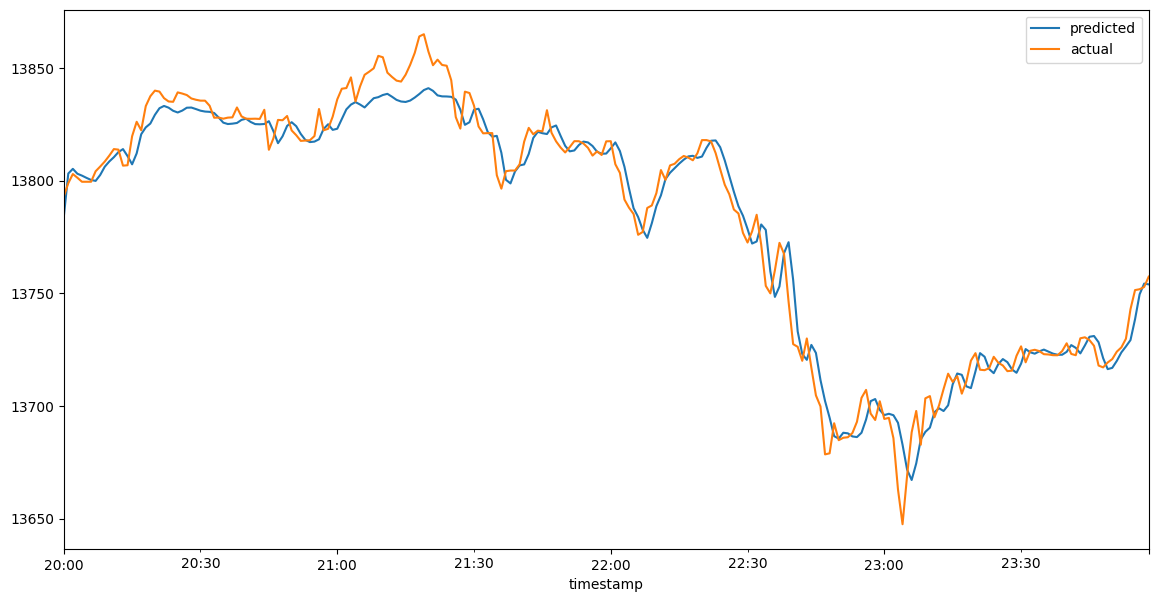

In [ ]:
df_result_1.plot(figsize=(14, 7))
plt.show()

Seems like a pretty good fit right? Why might this be misleading?

Let us look at the time series in more detail.

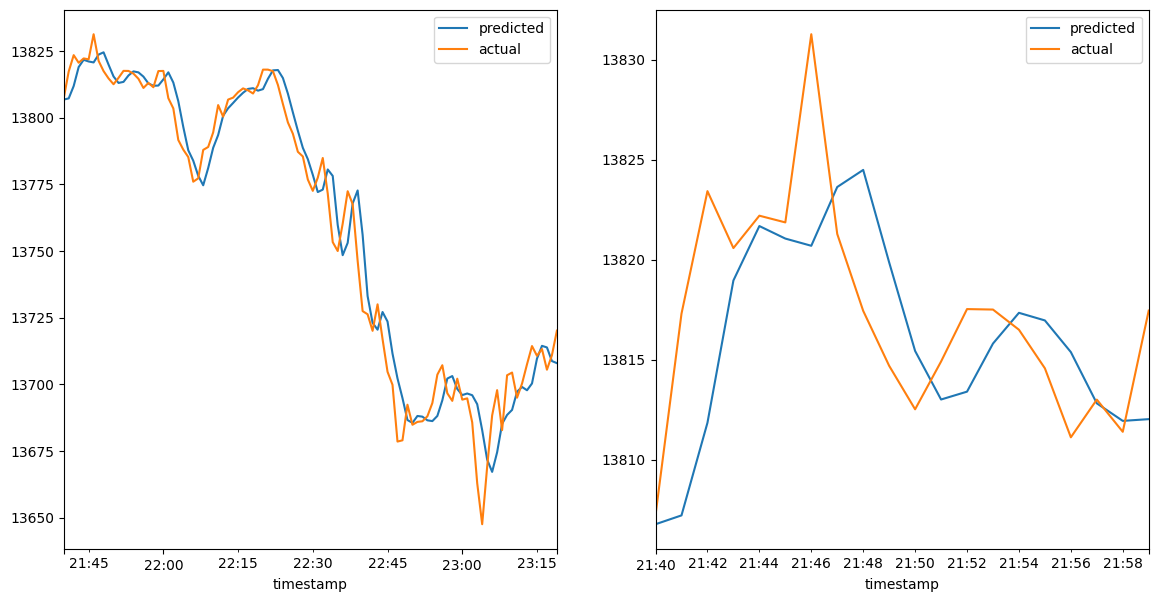

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[100:200].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[100:120].plot(ax=axes[1], figsize=(14, 7))
plt.show()

However, the basic RNNs may not be sufficient for practitioners when they face a wide range of sequence learning problems nowadays. Gated RNNs are more commonly used in practice.

## GRUs and LSTMs

We now revisit the case study and adjust the code to implement stacked versions of the GRU and LSTM cells.

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [ ]:
def train(train_loader, learn_rate, hidden_dim=20, EPOCHS=5, model_type="GRU"):

    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 5
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%250 == 0:
                print("Epoch {}\t Step: {}/{}\t Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.process_time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [ ]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU", EPOCHS=5)

Starting Training of GRU model
Epoch 1/5 Done, Total Loss: 0.29374880877803994
Time Elapsed for Epoch: 34.860951328999995 seconds
Epoch 2/5 Done, Total Loss: 0.051282246967088684
Time Elapsed for Epoch: 36.825847675000006 seconds
Epoch 3/5 Done, Total Loss: 0.03484942673037858
Time Elapsed for Epoch: 37.345929051 seconds
Epoch 4/5 Done, Total Loss: 0.028850264098818443
Time Elapsed for Epoch: 37.19882146500001 seconds
Epoch 5/5 Done, Total Loss: 0.025804087740781644
Time Elapsed for Epoch: 37.83002896100001 seconds
Total Training Time: 184.061578481 seconds


In [ ]:
def m_predict(model,x_test,model_type="GRU"):
    model.eval()
    outputs = torch.tensor([])
    with torch.no_grad():
        if model_type == "GRU":
            h =  torch.zeros(model.n_layers, 1, model.hidden_dim, dtype=torch.float32, device = device)
        else:
            h = (torch.zeros(model.n_layers, 1, model.hidden_dim, dtype=torch.float32, device = device),
                 torch.zeros(model.n_layers, 1, model.hidden_dim, dtype=torch.float32, device = device))
        out, h = model(x_test.to(device).float(), h)
    return(out.to("cpu"), h)


def evaluate(model,x_test,y_test, criterion = nn.MSELoss(),model_type="GRU"):
    model.eval()
    loss_eval = 0
    start_time = time.process_time()
    out,h = m_predict(model, x_test,model_type=model_type)
    loss_eval += criterion(out.to(device), y_test.to(device).float())
    print("Evaluation Time: {}".format(str(time.process_time()-start_time)))
    return out.to("cpu").reshape(-1,1), y_test.reshape(-1,1), loss_eval.to("cpu")


In [ ]:
m_predict(gru_model,x_test = test_data, model_type="GRU")

(tensor([[[ 0.7760],
          [ 1.2975],
          [ 1.5070],
          [ 1.5510],
          [ 1.3884],
          [ 1.2398],
          [ 1.1566],
          [ 1.0864],
          [ 1.1356],
          [ 1.1222],
          [ 1.1349],
          [ 1.1603],
          [ 1.1938],
          [ 1.1688],
          [ 1.0099],
          [ 1.0420],
          [ 1.2556],
          [ 1.3404],
          [ 1.2671],
          [ 1.4610],
          [ 1.5375],
          [ 1.6001],
          [ 1.6151],
          [ 1.5796],
          [ 1.5615],
          [ 1.5575],
          [ 1.6244],
          [ 1.6146],
          [ 1.6115],
          [ 1.5883],
          [ 1.5790],
          [ 1.5684],
          [ 1.5655],
          [ 1.5200],
          [ 1.4133],
          [ 1.4184],
          [ 1.3927],
          [ 1.3963],
          [ 1.3928],
          [ 1.4702],
          [ 1.3875],
          [ 1.3832],
          [ 1.3786],
          [ 1.3762],
          [ 1.3724],
          [ 1.4458],
          [ 1.0438],
          [ 1

In [ ]:
predicted,actual,test_loss_1 = evaluate(rnn_model,x_test = x_test, y_test = y_test, model_type="GRU")
print("Test loss %.4f" % test_loss_1)

Evaluation Time: 0.007070253999984288
Test loss 0.0369


In [ ]:
rescaled_values = scaler.inverse_transform(torch.cat((predicted,actual), dim = 1).numpy())
df_result_1 = pd.DataFrame(data=rescaled_values, columns=['predicted','actual'])
df_result_1.index = df_test.index[range(len(df_result_1))]

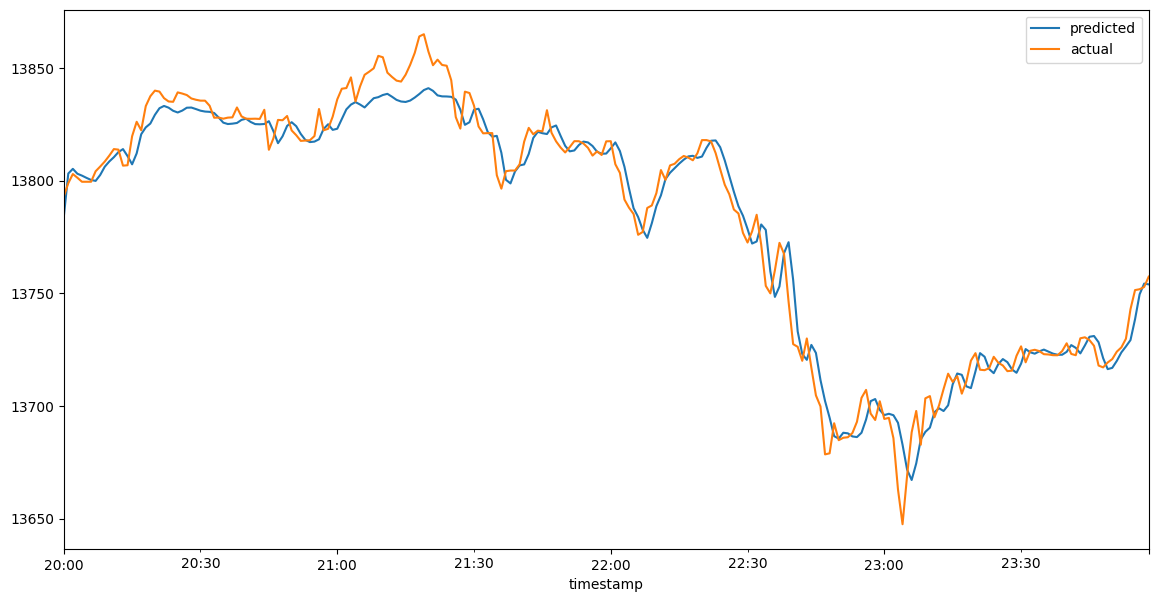

In [ ]:
df_result_1.plot(figsize=(14, 7))
plt.show()

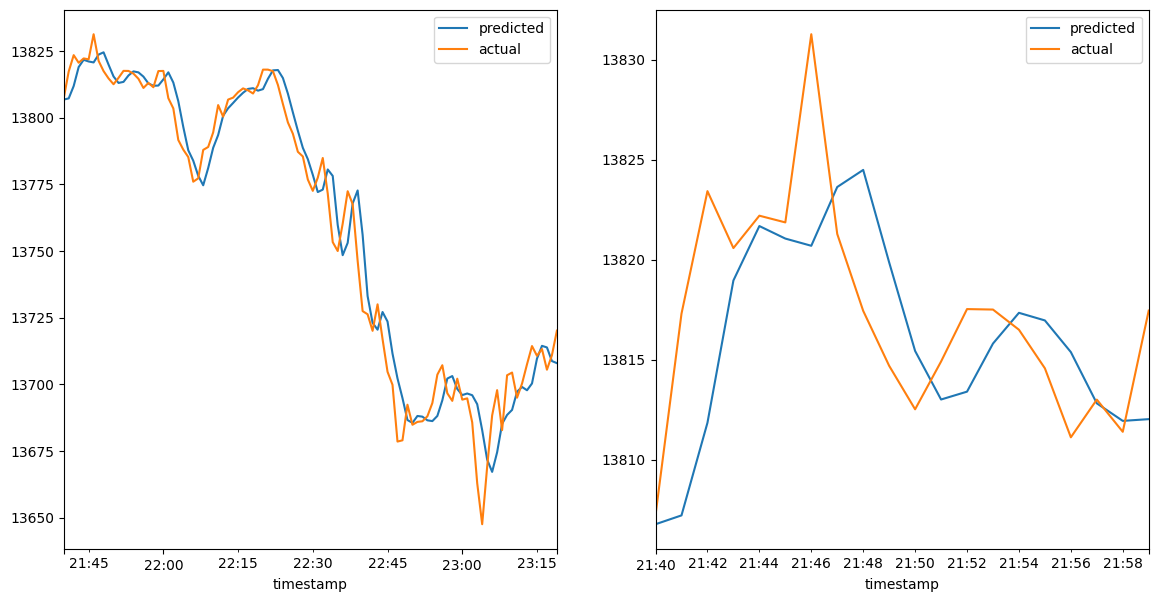

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[100:200].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[100:120].plot(ax=axes[1], figsize=(14, 7))
plt.show()

In [ ]:
lr = 0.001
lstm_model = train(train_loader, lr, model_type="LSTM", EPOCHS=5)

Starting Training of LSTM model
Epoch 1/5 Done, Total Loss: 0.4567641892627766
Time Elapsed for Epoch: 3.229485361000002 seconds
Epoch 2/5 Done, Total Loss: 0.057196923961105955
Time Elapsed for Epoch: 3.052235502000002 seconds
Epoch 3/5 Done, Total Loss: 0.03677680850301159
Time Elapsed for Epoch: 3.831306828999999 seconds
Epoch 4/5 Done, Total Loss: 0.030351155399255557
Time Elapsed for Epoch: 3.1548284960000217 seconds
Epoch 5/5 Done, Total Loss: 0.026860885721839728
Time Elapsed for Epoch: 3.090786969999982 seconds
Total Training Time: 16.358643158000007 seconds


In [ ]:
predicted,actual,test_loss_1 = evaluate(lstm_model,x_test = x_test, y_test = y_test, model_type="LSTM")

Evaluation Time: 0.009307322000012164


In [ ]:
test_loss_1

tensor(0.0246)

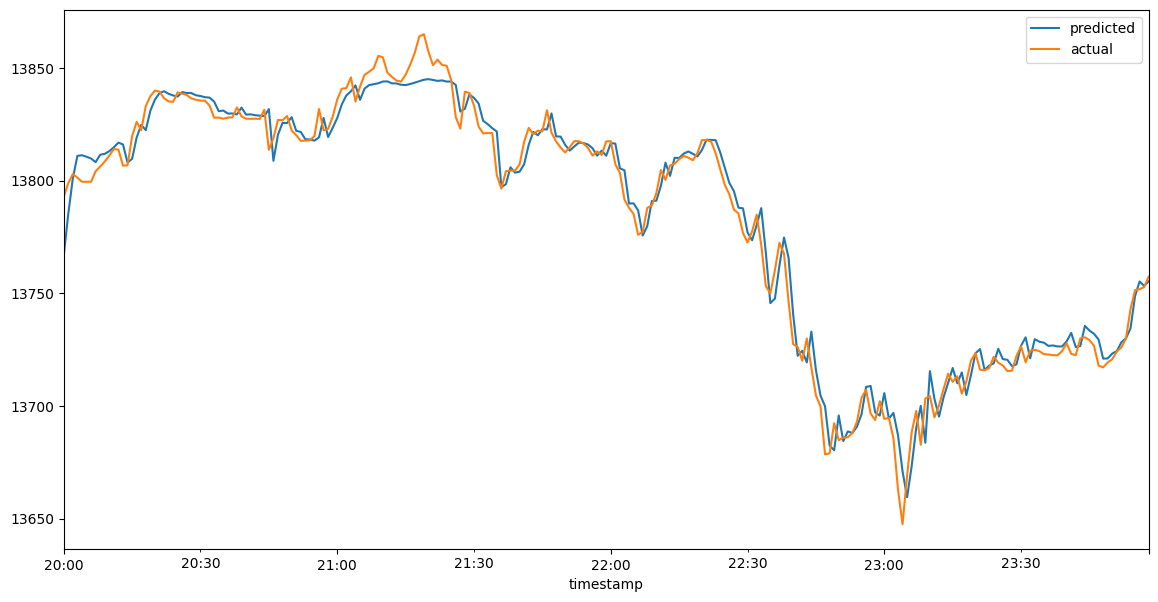

In [ ]:
rescaled_values = scaler.inverse_transform(torch.cat((predicted,actual), dim = 1).numpy())
df_result_1 = pd.DataFrame(data=rescaled_values, columns=['predicted','actual'])
df_result_1.index = df_test.index[range(len(df_result_1))]
df_result_1.plot(figsize=(14, 7))
plt.show()

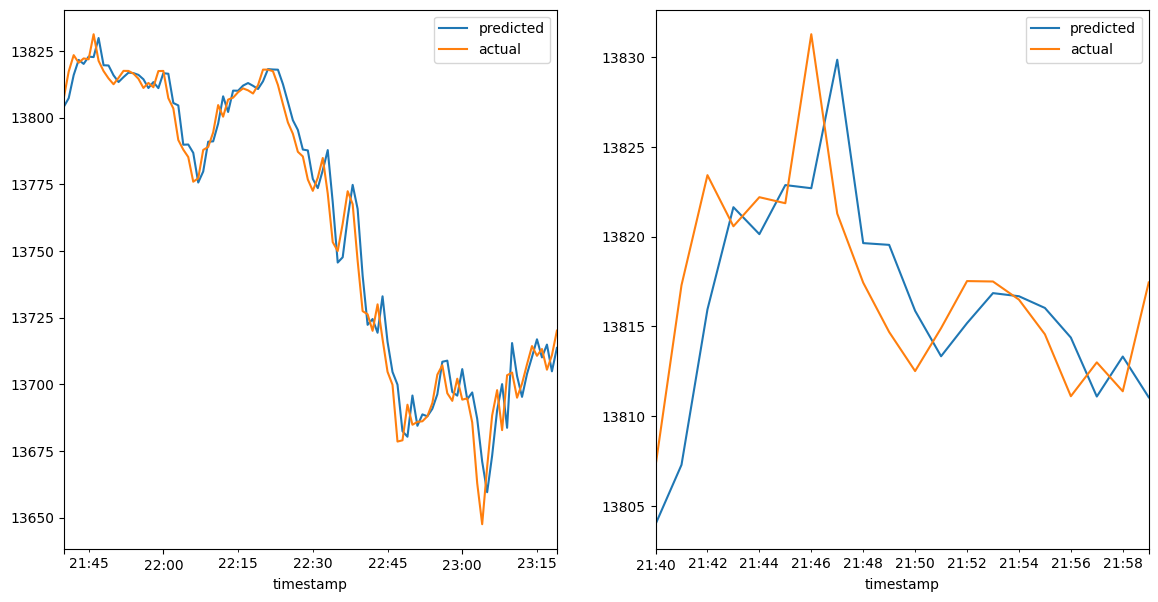

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[100:200].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[100:120].plot(ax=axes[1], figsize=(14, 7))
plt.show()